# Baseline framework. Step 3. Framework for experiments and submissions.

This notebook aims to provide an example of a baseline in ML competition.

As an example a Titanic competition on Kaggle was chosen https://www.kaggle.com/c/titanic

In [2]:
REPOSITORY_NAME = 'kaggle_titanic'

%cd {REPOSITORY_NAME}/notebooks/

## Import libraries

In [3]:
import os
import json

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

/Users/aguschin/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Read the data

In [4]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

sample_submission = pd.read_csv('../data/raw/gender_submission.csv')

## Prepare experiment results storage

In [5]:
class ScoreStore:
    """
    storing experiment results in file
    """
    def __init__(self, path_to_file: str):
        self.path_to_file = path_to_file

    def store(self, score: dict, add_timestamp=True):
        if add_timestamp:
            score['timestamp'] = str(pd.Timestamp.now())
        with open(self.path_to_file, 'a') as f:
            f.write(json.dumps(score))
            f.write('\n')
            
    def read(self):    
        with open(self.path_to_file, 'r') as f:
            content = f.readlines()
        content = [json.loads(row) for row in content]
        scores_df = pd.DataFrame(content)
        return scores_df

In [6]:
!rm ../reports/experiments.log
score_store = ScoreStore('../reports/experiments.log')

## Dummy submission

- metric
- dummy prediction
- kaggle api submission & getting results (function?)
- val vs LB score comparison

metric or loss function

In [7]:
# check if metric is already in sklearn.metrics
from sklearn.metrics import accuracy_score

In [8]:
# if not, write and test it
# having the same arguments as in sklearn.metrics function is nice
def accuracy(y_true, y_pred):
    assert len(y_true) == len(y_pred), 'different vector lengths'
    return (y_true == y_pred).mean()

accuracy(
    np.array([0, 1, 2]),
    np.array([0, 0, 0])
)

0.3333333333333333

dummy prediction

In [9]:
ycol = 'Survived'
train[ycol].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [10]:
accuracy(train[ycol], train[ycol] * 0)

0.6161616161616161

In [11]:
sample_submission[ycol] = 0

In [12]:
submission_name = 'constant.csv'
submission_path = os.path.join('../submissions/', submission_name)
sample_submission.to_csv(submission_path, index=False)

In [13]:
to_log = dict(fileName=submission_name, metric='accuracy', score_mean=0.61)
score_store.store(to_log)

## Validation

- train/val split
- dump used split ids & upload to git for exchange
- cv function?
- submit & score comparison (?)
- val/test switch (dev/prod)
- calc val std
- a possibility to change seed sometimes
- dump val + test predictions & upload to git for exchange

Два сценария:
1. более удобный когда есть test.csv; больше шанс по своей ошибке сделать себе лик при генерации фичей или допустить ошибку в кросс-валидации :)
    
    > использовать ids в функциях по валидации, трейн не делить на трейн/валидацию, трейн и тест объединять
1. более удобный, когда нет test.csv

    > разбивать на x_train, x_test и использовать трансформеры
    
### Scenario 2

restart & run all your notebook every time you want to change validation mode and re-run next cell
thus you will make sure that:
- your results are repeatable
- your notebook is not too complicated for "Run All"

The last one is important because:
- more complicated your notebook is, more likely you will make a mistake
- the moment you start to notice it is a good time to make some clean-up

#### example
For example, if your EDA or data preprocessing or model tuning starts to be very complicated and need a takes a lot of space in notebook or time to run, you could take it to some other notebook and dump intermediate results on disk.

If you have one complicated notebook "Framework.ipynb" containing:
- EDA
- Data processing
- Modeling
- Submitting

Split it and dump intermediate results in "../data/processed/":
- Eda.ipynb
- DataProcessing.ipynb
- ModelAndSubmit.ipynb

In [24]:
MODE = 'validation_dump'
idcol = 'PassengerId'

if MODE == 'validation_dump':
    X = train[[c for c in train if c != ycol]].copy()
    y = train[ycol].copy()
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # dump used split ids as backup
    x_train[[idcol]].to_csv('../data/processed/x_train_ids.csv', index=False)
    x_test[[idcol]].to_csv('../data/processed/x_test_ids.csv', index=False)

elif MODE == 'validation_load':
    x_train_ids = pd.read_csv('../data/processed/x_train_ids.csv')
    x_test_ids = pd.read_csv('../data/processed/x_test_ids.csv')

    x_train = X.set_index(idcol).loc[x_train_ids[idcol]]
    x_test = X.set_index(idcol).loc[x_test_ids[idcol]]

elif MODE == 'test':
    x_train = train[[c for c in train if c != ycol]].copy()
    y_train = train[ycol].copy()
    x_test = test.copy()
    y_test = np.random.choice(y, size=len(x_test))

In [25]:
!head -4 ../data/processed/x_train_ids.csv

PassengerId
141
440
818


In [27]:
FUNCTION = log_loss


def cv_mode(CV):
    if CV:
        cv = KFold(n_splits=5, shuffle=False, random_state=42).split(data.iloc[:train.shape[0]])    
    else:
        i_tr = data.iloc[:train.shape[0]].index
        i_tst = data.iloc[train.shape[0]:].index
        cv = (i_tr, i_tst)
    return cv


def make_prediction(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    prediction = model.predict_proba(X_test)
    return prediction

    
def cross_val(model, X, y):
    cv = KFold(n_splits=3, shuffle=True, random_state=0).split(X)
    scores = []
    for itr, ival in cv:
        y_pred = make_prediction(model, X.iloc[itr], y.iloc[itr], X.iloc[ival])
        score = FUNCTION(y.iloc[ival], y_pred)
        scores.append(score)
    return np.mean(scores), np.std(scores)


clf = DummyClassifier('prior')

score_mean, score_std = cross_val(clf, x_train, y_train)
to_log = dict(clf=str(clf), metric=log_loss.__name__, score_mean=score_mean, score_std=score_std)
score_store.store(to_log)

In [28]:
score_store.read()

,clf,fileName,metric,score_mean,score_std,timestamp
0,NaN,constant.csv,accuracy,0.610000,NaN,2019-10-18 13:10:33.551342
1,"DummyClassifier(constant=None, random_state=No...",NaN,log_loss,0.667854,0.014531,2019-10-18 13:15:58.234647


### Scenario 1
сейчас тут просто наброски кода для примера

In [34]:
# Объединим трейн и тест

test['price'] = -1

data = pd.concat([train, test], 0)
data.reset_index(drop=True, inplace=True)

In [ ]:
from sklearn.model_selection import KFold

# Эта функция определяет что нам сейчас нужно на некотором наборе данных. Кросс валидация, или предсказания для теста.

def cv_mode(CV):
    
    if CV:
    
        cv = KFold(n_splits=5, shuffle=False, random_state=42).split(data.iloc[:train.shape[0]])
    
    else:
        i_tr = data.iloc[:train.shape[0]].index
        i_tst = data.iloc[train.shape[0]:].index
        cv = (i_tr, i_tst)
    
    return cv

In [37]:
# Получить предсказания, кросс-валидация, файл с решением

def make_prediction(model, X, y, i_tr, i_tst):
    X_train, X_test = X.iloc[i_tr, :], X.iloc[i_tst, :]
    y_train, y_test = y.iloc[i_tr], y.iloc[i_tst]
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    return prediction, MAPE(y_test, prediction)
        
    
def cross_val(model, X, y, CV=True):
    cv = cv_mode(CV)
    scores = []
    for i_tr, i_tst in cv:
        _, score = make_prediction(model, X, y, i_tr, i_tst)
        scores.append(score)
    return np.mean(scores), np.std(scores)


def make_subm(model, X, y, filename, CV=False):
    cv = cv_mode(CV)
    (i_tr, i_tst) = cv
    prediction, _ = make_prediction(model, X, y, i_tr, i_tst)
    subm['price'] = prediction
    subm.to_csv(filename, index=False)
    pass



## Data preprocessing
- dump intermediate results with joblib
- quick preprocessing + simple model baseline
- try sklearn Pipeline ?
- show sklearn Transformer ?

In [29]:
class DataTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        self.label_encoders = dict()
        for column in ['Sex', 'Cabin', 'Embarked']:
            self.label_encoders[column] = LabelEncoder().fit(X[column].fillna('MISSING'))
        return self

    def transform(self, X):
        X = X.copy()
        for column, le in self.label_encoders.items():
            X[column] = X[column].fillna('MISSING')
            X.loc[~X[column].isin(le.classes_), column] = 'MISSING'
            X[column + '_le'] = le.transform(X[column])
        return X

In [30]:
transformer = DataTransformer().fit(x_train)
x_train_ = transformer.transform(x_train)
x_test_ = transformer.transform(x_test)

## Model exploration
- try different models
- try some tuning
- analyse model performance results

In [31]:
for clf in [
    LogisticRegression(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
    LGBMClassifier(),
]:
    print(clf)
    score_mean, score_std = cross_val(clf, x_train_.select_dtypes(exclude='O').fillna(0), y_train)
    print(score_mean, score_std, end='\n\n')
    to_log = dict(clf=str(clf), metric=log_loss.__name__, score_mean=score_mean, score_std=score_std)
    score_store.store(to_log)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.485596929681158 0.04441021605665752

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
2.347854167292343 0.5856196604035674

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_s

/Users/aguschin/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/aguschin/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/aguschin/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/aguschin/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



0.6119220117887324 0.12801896634362545



In [32]:
score_store.read()

,clf,fileName,metric,score_mean,score_std,timestamp
0,NaN,constant.csv,accuracy,0.610000,NaN,2019-10-18 13:10:33.551342
1,"DummyClassifier(constant=None, random_state=No...",NaN,log_loss,0.667854,0.014531,2019-10-18 13:15:58.234647
2,"LogisticRegression(C=1.0, class_weight=None, d...",NaN,log_loss,0.485597,0.044410,2019-10-18 13:16:22.137659
3,"KNeighborsClassifier(algorithm='auto', leaf_si...",NaN,log_loss,2.347854,0.585620,2019-10-18 13:16:22.160313
4,"RandomForestClassifier(bootstrap=True, class_w...",NaN,log_loss,1.604999,0.696229,2019-10-18 13:16:22.227084
5,"LGBMClassifier(boosting_type='gbdt', class_wei...",NaN,log_loss,0.611922,0.128019,2019-10-18 13:16:23.203036


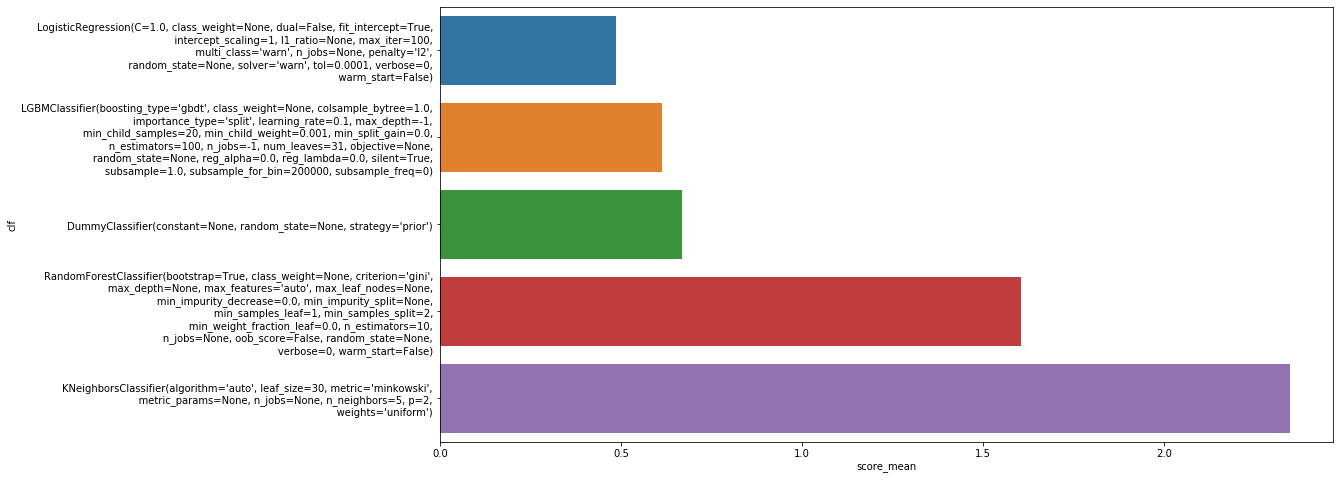

In [33]:
plt.figure(figsize=(16, 8))
val_scores_subset = score_store.read().query('metric == "log_loss"').sort_values('score_mean')
sns.barplot(data=val_scores_subset, x='score_mean', y='clf')

In [189]:
model = LGBMClassifier()
cross_val(model, x_train_.select_dtypes(exclude='O'), y_train)

(0.6176005090381698, 0.15641759171620387)

## Submit & commit
- git add -An
- gitignore
- git lfs + gitattributes

In [ ]:
MESSAGE = 'LGBM-super-stacked + NN averaged 10 fold'
submit.to_csv(FILE)

In [259]:
%%bash

export COMPETITION="titanic"
export MESSAGE="constant submission"
export SUBMISSION_PATH="../submissions/constant.csv"

# git pull
git add -A
git commit -m '$MESSAGE'
# git push
# kaggle competitions submit -c $COMPETITION -f $SUBMISSION_PATH -m "$MESSAGE"
sleep 1
kaggle competitions submissions -c $COMPETITION -v > ../reports/submissions.csv

[master e999d16] $MESSAGE
 4 files changed, 662 insertions(+)
 create mode 100644 reports/experiments.csv
 create mode 100644 reports/pandas_profiling_report_raw_test_data.html
 create mode 100644 reports/pandas_profiling_report_raw_train_data.html
 create mode 100644 submissions/submissions.csv


In [36]:
ns = np.arange(1, 6)
np.random.shuffle(ns)
ns

array([5, 4, 2, 1, 3])

## Visualising your progress
- Store experiment (val) results and submit results in one table
- Store val results and LB results for each submit
- Describe submission in tags to make further analysis easier
- 

In [14]:
submission_scores = pd.read_csv('../reports/submissions.csv')
submission_scores = submission_scores.query('publicScore != "None"')
submission_scores['publicScore'] = submission_scores['publicScore'].astype(float)

In [15]:
submission_scores

,fileName,date,description,status,publicScore,privateScore
0,constant.csv,2019-10-16 06:15:28,constant submission,complete,0.62679,None
1,constant.csv,2019-10-16 06:10:41,constant submission,complete,0.62679,None
2,submit01.csv,2015-09-24 12:26:52,None,complete,0.73205,None


https://seaborn.pydata.org/examples/horizontal_barplot.html

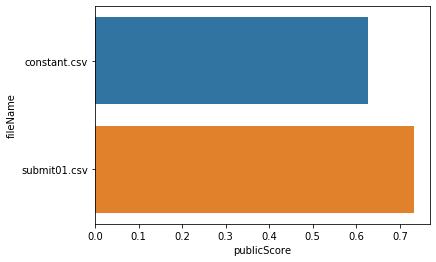

In [16]:
sns.barplot(data=submission_scores, x='publicScore', y='fileName')

Сравним результаты на валидации и паблик LB

In [17]:
val_lb_scores = submission_scores.merge(score_store.read(), on=['fileName'])
val_lb_scores

,fileName,date,description,status,publicScore,privateScore,metric,score_mean,timestamp
0,constant.csv,2019-10-16 06:15:28,constant submission,complete,0.62679,None,accuracy,0.61,2019-10-18 13:10:33.551342
1,constant.csv,2019-10-16 06:10:41,constant submission,complete,0.62679,None,accuracy,0.61,2019-10-18 13:10:33.551342


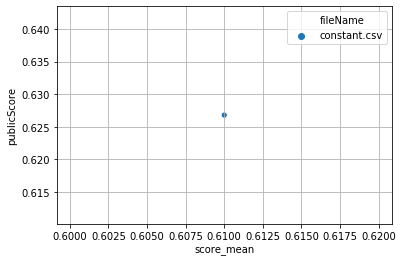

In [23]:
sns.scatterplot(data=val_lb_scores, x='score_mean', y='publicScore', hue='fileName')
plt.grid()